# WebReg Statistical Analysis

**Objective**: Analyze enrollment data to identify key features predicting utilization rates, perform hypothesis testing, and calculate feature importance.


In [2]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 7.4 MB/s  0:00:01m0:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr, spearmanr
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)


## Data Loading & Feature Engineering


In [4]:
def load_all_webreg_data():
    quarters = ['fa24', 'wi25', 'sp25']
    quarter_labels = {'fa24': 'Fall 2024', 'wi25': 'Winter 2025', 'sp25': 'Spring 2025'}
    quarter_numeric = {'fa24': 1, 'wi25': 2, 'sp25': 3}
    
    all_data = []
    
    for quarter in quarters:
        for division in ['lower_division', 'upper_division']:
            data_path = Path(f'webreg_data/{quarter}/{division}')
            if not data_path.exists():
                continue
            
            for csv_file in data_path.glob('DSC_*.csv'):
                df = pd.read_csv(csv_file)
                if len(df) == 0 or df['total'].iloc[-1] == 0:
                    continue
                
                final_row = df.iloc[-1]
                course_name = csv_file.stem
                course_num = course_name.replace('DSC_', '')
                
                match = re.match(r'(\d+)', course_num)
                if not match:
                    continue
                course_number = int(match.group(1))
                
                record = {
                    'course': course_name,
                    'course_number': course_number,
                    'quarter': quarter,
                    'quarter_label': quarter_labels[quarter],
                    'quarter_numeric': quarter_numeric[quarter],
                    'enrolled': final_row['enrolled'],
                    'available': final_row['available'],
                    'waitlisted': final_row['waitlisted'],
                    'total_capacity': final_row['total'],
                    'division': division,
                    'is_upper_division': 1 if division == 'upper_division' else 0,
                    'is_lower_division': 1 if division == 'lower_division' else 0,
                }
                all_data.append(record)
    
    return pd.DataFrame(all_data)

df = load_all_webreg_data()
print(f"Loaded {len(df)} observations, {df['course'].nunique()} unique courses")


Loaded 45 observations, 20 unique courses


In [5]:
import os
os.makedirs("webreg_data/results", exist_ok=True)

# Course classification
REQUIRED_COURSES = {
    'DSC_10', 'DSC_20', 'DSC_30', 'DSC_40A', 'DSC_40B', 'DSC_80',
    'DSC_100', 'DSC_102', 'DSC_106', 'DSC_180A', 'DSC_180B', 'DSC_190'
}

# Add features
df['is_required'] = df['course'].apply(lambda x: 1 if x in REQUIRED_COURSES else 0)
df['is_elective'] = 1 - df['is_required']
df['requirement_type'] = df['is_required'].map({1: 'Required', 0: 'Elective'})

df['utilization_rate'] = (df['enrolled'] / df['total_capacity'] * 100).round(2)
df['waitlist_rate'] = (df['waitlisted'] / df['total_capacity'] * 100).round(2)
df['available_rate'] = (df['available'] / df['total_capacity'] * 100).round(2)
df['demand_pressure'] = (df['enrolled'] + df['waitlisted']) / df['total_capacity'] * 100
df['is_oversubscribed'] = (df['utilization_rate'] >= 95).astype(int)
df['has_waitlist'] = (df['waitlisted'] > 0).astype(int)

course_frequency = df.groupby('course')['quarter'].nunique().to_dict()
df['quarters_offered'] = df['course'].map(course_frequency)
df['is_every_quarter'] = (df['quarters_offered'] == 3).astype(int)

df['is_fall'] = (df['quarter'] == 'fa24').astype(int)
df['is_winter'] = (df['quarter'] == 'wi25').astype(int)
df['is_spring'] = (df['quarter'] == 'sp25').astype(int)

df.to_csv('webreg_data/results/webreg_processed_data.csv', index=False)
df.head()


,course,course_number,quarter,quarter_label,quarter_numeric,enrolled,available,waitlisted,total_capacity,division,...,waitlist_rate,available_rate,demand_pressure,is_oversubscribed,has_waitlist,quarters_offered,is_every_quarter,is_fall,is_winter,is_spring
0,DSC_80,80,fa24,Fall 2024,1,202,38,0,240,lower_division,...,0.0,15.83,84.166667,0,0,3,1,1,0,0
1,DSC_95,95,fa24,Fall 2024,1,10,40,0,50,lower_division,...,0.0,80.00,20.000000,0,0,3,1,1,0,0
2,DSC_90,90,fa24,Fall 2024,1,7,13,0,20,lower_division,...,0.0,65.00,35.000000,0,0,1,0,1,0,0
3,DSC_20,20,fa24,Fall 2024,1,74,76,0,150,lower_division,...,0.0,50.67,49.333333,0,0,3,1,1,0,0
4,DSC_40A,40,fa24,Fall 2024,1,158,7,0,165,lower_division,...,0.0,4.24,95.757576,1,0,3,1,1,0,0


## Hypothesis Testing

### Research Hypothesis Framework

**Null Hypothesis (H₀)**: Enrollment demand and seat utilization do not differ between:
- Required vs. elective courses
- Lower-division vs. upper-division courses  

**Alternative Hypothesis (H₁)**: 
1. Required DSC courses show higher enrollment and utilization than elective courses
2. Lower-division DSC courses show higher enrollment and utilization than upper-division courses
3. Courses offered once per year exhibit higher seat utilization than courses offered every quarter

---

### Statistical Tests Mapped to Hypotheses

| Test | Hypothesis Component | Method | Purpose |
|------|---------------------|--------|---------|
| **Test 1** | H₁ Part 1: Required vs. Elective | Two-Sample t-test | Directly tests if required courses have higher utilization |
| **Test 2** | H₁ Part 2: Lower vs. Upper Division | Two-Sample t-test | Directly tests if lower-division courses have higher utilization |
| **Test 3** | Control variable | One-Way ANOVA | Tests if quarter affects utilization (control for seasonality) |
| **Test 4** | H₁ Parts 1 & 2 interaction | Two-Way ANOVA | Tests if division and requirement effects are independent or interact |
| **Test 5** | H₁ extreme cases | Chi-Square | Tests if required courses are more likely to be at capacity (≥95%) |
| **Test 6** | Confounding factor | Correlation | Tests if class size confounds utilization patterns |

**Note on H₁ Part 3** (courses offered once vs. every quarter): This will be tested using the `quarters_offered` variable in the regression models (Tests 7-8) rather than a separate hypothesis test.

---


### T-Test: Required vs. Elective


In [6]:
required_util = df[df['is_required'] == 1]['utilization_rate']
elective_util = df[df['is_required'] == 0]['utilization_rate']

t_stat, p_value = ttest_ind(required_util, elective_util)

print(f"Required: n={len(required_util)}, mean={required_util.mean():.2f}%")
print(f"Elective: n={len(elective_util)}, mean={elective_util.mean():.2f}%")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.6f}")
print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")


Required: n=31, mean=82.69%
Elective: n=14, mean=65.51%
t-statistic: 2.9789, p-value: 0.004741
Significant: Yes


#### Interpretation:
**What this means for your research:**
- If p < 0.05 and required mean > elective mean: **Supports your hypothesis** that required courses face higher demand
- The mean difference shows the practical significance (e.g., 15% higher utilization is substantial)
- This directly addresses Research Question 1 about course structure and demand


### Test 2: Two-Sample T-Test - Lower vs. Upper Division

**Purpose:** Test if lower division courses have different utilization rates than upper division courses.

**Null Hypothesis (H₀):** There is no difference in mean utilization between lower and upper division courses.

**Alternative Hypothesis (H₁):** Lower division courses have higher utilization than upper division courses.

**Interpretation Guide:**
- If **p < 0.05**: Significant difference exists between division levels
- Positive t-statistic suggests lower division has higher utilization
- This tests whether intro courses face more enrollment pressure than advanced courses


In [7]:
lower_util = df[df['is_lower_division'] == 1]['utilization_rate']
upper_util = df[df['is_upper_division'] == 1]['utilization_rate']

t_stat, p_value = ttest_ind(lower_util, upper_util)

print(f"Lower: n={len(lower_util)}, mean={lower_util.mean():.2f}%")
print(f"Upper: n={len(upper_util)}, mean={upper_util.mean():.2f}%")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.6f}")
print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")


Lower: n=23, mean=73.64%
Upper: n=22, mean=81.23%
t-statistic: -1.3199, p-value: 0.193837
Significant: No


#### Interpretation:
**What this means for your research:**
- Significant results (p < 0.05) indicate division level affects enrollment demand
- If lower division mean > upper division mean: Suggests bottleneck at intro level
- Non-significant results suggest similar demand patterns across all course levels
- Combined with Test 1, helps distinguish between requirement status vs. course level effects


### Test 3: One-Way ANOVA - Utilization Across Quarters

**Purpose:** Test if utilization rates differ significantly across Fall 2024, Winter 2025, and Spring 2025.

**Null Hypothesis (H₀):** All quarters have the same mean utilization rate.

**Alternative Hypothesis (H₁):** At least one quarter differs in mean utilization.

**Interpretation Guide:**
- If **p < 0.05**: Significant quarterly variation exists
- F-statistic measures variance between quarters vs. within quarters
- Helps identify if seasonal patterns or offering timing matters

---

### Test 4: Two-Way ANOVA - Division × Requirement Type Interaction

**Purpose:** Test if the effect of being required differs by division level (interaction effect).

**What this tests:**
- Main effect of Division
- Main effect of Requirement Type
- **Interaction effect**: Does being required matter MORE for lower division than upper division?

**Interpretation Guide:**
- Significant interaction (p < 0.05) means the effect of one factor depends on the other
- Example: Required courses may show bigger utilization boost in lower division than upper division


In [8]:
# One-way ANOVA: Quarters
groups = [df[df['quarter'] == q]['utilization_rate'].values for q in df['quarter'].unique()]
f_stat, p_value = f_oneway(*groups)
print(f"Quarters ANOVA: F={f_stat:.4f}, p={p_value:.6f}, Significant: {'Yes' if p_value < 0.05 else 'No'}")

# Two-way ANOVA: Division × Requirement
formula = 'utilization_rate ~ C(division) + C(requirement_type) + C(division):C(requirement_type)'
model = ols(formula, data=df).fit()
anova_table = anova_lm(model, typ=2)
anova_table


Quarters ANOVA: F=0.0686, p=0.933839, Significant: No


,sum_sq,df,F,PR(>F)
C(division),1392.289925,1.0,4.780872,0.034540
C(requirement_type),3591.633447,1.0,12.333020,0.001098
C(division):C(requirement_type),466.278850,1.0,1.601117,0.212889
Residual,11940.057864,41.0,NaN,NaN


#### Interpretation:
**One-Way ANOVA (Quarters):**
- Significant result suggests enrollment patterns vary by academic term
- Could indicate: different cohort sizes, prerequisite timing, or course offering patterns
- Non-significant result suggests consistent demand regardless of quarter

**Two-Way ANOVA (Interaction):**
- Look at the interaction term p-value in the ANOVA table
- Significant interaction validates examining required/elective separately for each division
- Main effects show individual impacts; interaction shows combined effect
- This is crucial for understanding whether your hypothesis applies uniformly or varies by context


### Test 5: Chi-Square Test - Overenrolled by Course Type

**Purpose:** Test if required courses are more likely to be overenrolled (≥95% full) than elective courses.

**Null Hypothesis (H₀):** Course type (required/elective) and overnenrollment status are independent.

**Alternative Hypothesis (H₁):** Required courses are associated with higher overnenrollment rates.

**Interpretation Guide:**
- If **p < 0.05**: Significant association exists
- Look at contingency table to see which cell has higher-than-expected counts
- This tests extreme demand (not just average utilization)

---

### Test 6: Correlation - Total Capacity vs. Utilization Rate

**Purpose:** Test if class size (total capacity) relates to how full the class gets.

**What we're testing:**
- **Pearson r**: Linear relationship (assumes normal distribution)
- **Spearman ρ**: Rank-based relationship (more robust to outliers)

**Interpretation Guide:**
- Negative correlation: Larger classes have lower utilization (harder to fill)
- Positive correlation: Larger classes have higher utilization
- Near-zero correlation: Class size doesn't predict utilization
- Compare Pearson vs Spearman to detect non-linear relationships


In [9]:
# Chi-square: Oversubscription by type
contingency_table = pd.crosstab(df['requirement_type'], df['is_oversubscribed'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square: χ²={chi2:.4f}, p={p_value:.6f}, Significant: {'Yes' if p_value < 0.05 else 'No'}")
print("\nContingency Table:")
print(contingency_table)

# Correlation: Capacity vs Utilization
pearson_r, pearson_p = pearsonr(df['total_capacity'], df['utilization_rate'])
spearman_r, spearman_p = spearmanr(df['total_capacity'], df['utilization_rate'])
print(f"\nCapacity vs Utilization:")
print(f"Pearson: r={pearson_r:.4f}, p={pearson_p:.6f}")
print(f"Spearman: ρ={spearman_r:.4f}, p={spearman_p:.6f}")


Chi-square: χ²=0.4775, p=0.489570, Significant: No

Contingency Table:
is_oversubscribed   0  1
requirement_type        
Elective           12  2
Required           22  9

Capacity vs Utilization:
Pearson: r=0.3139, p=0.035731
Spearman: ρ=0.2840, p=0.058692


#### Interpretation:
**Chi-Square Test:**
- Significant result (p < 0.05) means required courses are disproportionately oversubscribed
- This goes beyond average utilization to show capacity constraints
- Important for resource allocation and scheduling recommendations

**Correlation Analysis:**
- Significant correlation helps predict utilization based on class size
- Useful for planning: "If we increase capacity to X seats, expect Y% utilization"
- Negative correlation might suggest demand is capped by prerequisites, not capacity
- This informs whether expanding class size solves enrollment pressure


## Linear Regression


### Test 7: Simple Linear Regressions (Univariate Analysis)

**Purpose:** Test each predictor individually to see its relationship with utilization rate.

**What this shows:**
- **Coefficient**: Direction and magnitude of relationship (e.g., +15 means 15% higher utilization)
- **p-value**: Statistical significance of the relationship
- **R²**: How much variance this single predictor explains (0-1 scale)

**Why run simple regressions:**
- Identify which features have strong univariate relationships
- Detect direction of effects before accounting for confounders
- Compare to multiple regression to see how effects change when controlling for other variables

**Interpretation Guide:**
- p < 0.05: This predictor significantly affects utilization on its own
- Higher |coefficient|: Stronger practical effect
- Higher R²: Better single-predictor model


In [10]:
import os
os.makedirs("webreg_data/results", exist_ok=True)

predictors = ['is_required', 'is_upper_division', 'total_capacity', 'quarters_offered', 
              'is_every_quarter', 'waitlisted', 'demand_pressure', 'course_number']

results = []
for predictor in predictors:
    X = sm.add_constant(df[[predictor]])
    model = sm.OLS(df['utilization_rate'], X).fit()
    results.append({
        'predictor': predictor,
        'coefficient': model.params[1],
        'std_error': model.bse[1],
        't_stat': model.tvalues[1],
        'p_value': model.pvalues[1],
        'r_squared': model.rsquared
    })

simple_reg_results = pd.DataFrame(results).sort_values('p_value')
simple_reg_results.to_csv('webreg_data/results/simple_regression_results.csv', index=False)
simple_reg_results


,predictor,coefficient,std_error,t_stat,p_value,r_squared
6,demand_pressure,0.968276,0.011719,82.625554,5.116934e-49,0.993741
0,is_required,17.182903,5.768264,2.978869,4.741498e-03,0.171063
5,waitlisted,2.560658,1.117382,2.291658,2.688462e-02,0.108840
2,total_capacity,0.063655,0.029360,2.168098,3.573073e-02,0.098545
1,is_upper_division,7.592510,5.752137,1.319946,1.938371e-01,0.038940
7,course_number,0.012470,0.053131,0.234707,8.155506e-01,0.001279
4,is_every_quarter,1.133889,7.330539,0.154680,8.777972e-01,0.000556
3,quarters_offered,0.558336,3.989529,0.139950,8.893526e-01,0.000455


### Test 8: Multiple Linear Regression (Multivariate Analysis)

**Purpose:** Estimate the effect of each predictor while controlling for all other predictors simultaneously.

**Model Equation:**
```
Utilization Rate = β₀ + β₁(is_required) + β₂(is_upper_division) + β₃(total_capacity) 
                   + β₄(quarters_offered) + β₅(waitlisted) + β₆(is_fall) 
                   + β₇(is_winter) + β₈(course_number) + ε
```

**Why multiple regression:**
- Controls for confounding variables
- Shows **independent** effect of each predictor
- Coefficients may change from simple regression (that's expected!)
- More realistic model that accounts for complexity

**Key Metrics to Check:**
- **R²**: Overall model fit (% of variance explained)
- **Adjusted R²**: R² penalized for number of predictors
- **F-statistic p-value**: Is the overall model significant?
- **Individual p-values**: Which predictors matter when controlling for others?


In [11]:
import os
os.makedirs("webreg_data/results", exist_ok=True)

feature_columns = ['is_required', 'is_upper_division', 'total_capacity', 'quarters_offered',
                   'waitlisted', 'is_fall', 'is_winter', 'course_number']

X = sm.add_constant(df[feature_columns])
multi_model = sm.OLS(df['utilization_rate'], X).fit()

print(multi_model.summary())

coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + feature_columns,
    'Coefficient': multi_model.params,
    'Std_Error': multi_model.bse,
    't_stat': multi_model.tvalues,
    'p_value': multi_model.pvalues
})
coef_df.to_csv('webreg_data/results/multiple_regression_coefficients.csv', index=False)
coef_df


                            OLS Regression Results                            
Dep. Variable:       utilization_rate   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     2.656
Date:                Tue, 09 Dec 2025   Prob (F-statistic):             0.0212
Time:                        18:29:33   Log-Likelihood:                -186.47
No. Observations:                  45   AIC:                             390.9
Df Residuals:                      36   BIC:                             407.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                63.4022     15.67

,Feature,Coefficient,Std_Error,t_stat,p_value
const,Intercept,63.402246,15.671039,4.045823,0.000264
is_required,is_required,19.681340,6.793948,2.896893,0.006375
is_upper_division,is_upper_division,7.115237,9.797408,0.726237,0.472389
total_capacity,total_capacity,0.020805,0.032094,0.648235,0.520947
quarters_offered,quarters_offered,-3.510647,3.981156,-0.881816,0.383726
waitlisted,waitlisted,2.439019,1.062357,2.295856,0.027614
is_fall,is_fall,-2.748504,6.381732,-0.430683,0.669267
is_winter,is_winter,-0.662026,6.406629,-0.103335,0.918271
course_number,course_number,0.021713,0.097745,0.222140,0.825460


#### Interpretation:
**How to read the regression output:**

1. **Overall Model (top section):**
   - **R-squared**: % of variance in utilization explained by all predictors together
   - **Adj. R-squared**: More conservative estimate (use this for model comparison)
   - **F-statistic p-value**: If < 0.05, model as a whole is significant

2. **Individual Coefficients (bottom table):**
   - **coef**: Change in utilization % for one unit increase in predictor (holding others constant)
   - **P>|t|**: p-value for this specific predictor
   - **Significance codes**: *** p<0.001, ** p<0.01, * p<0.05

3. **What to report:**
   - "After controlling for all other factors, required courses have X% higher utilization (p=Y)"
   - Focus on significant predictors (p < 0.05)
   - Compare coefficients to see relative importance

**Comparing to Simple Regression:**
- If a coefficient changes dramatically, there was confounding
- If p-value changes, the effect depends on other variables
- This is the model to use for causal claims (not simple regression)


## Feature Importance Analysis

**Goal:** Rank features by their predictive power for utilization rate using multiple complementary methods.

**Why three different methods?**
- Each captures a different aspect of "importance"
- Triangulating across methods gives robust rankings
- Different methods suit different contexts (linear vs non-linear, scaled vs unscaled)

**Methods Overview:**
1. **Standardized Coefficients**: Linear effect when all features on same scale
2. **Permutation Importance**: Model performance drop when feature is shuffled
3. **Correlation**: Simple bivariate association with target


### Method 1: Standardized Coefficients

**How it works:**
- Scales all features to mean=0, std=1
- Runs regression on scaled features
- Coefficients now directly comparable (all in same units)

**Interpretation:**
- Larger absolute value = more important
- Sign shows direction (positive/negative effect)
- Assumes linear relationships
- Best for: Understanding relative effect sizes in linear models


In [12]:
X = df[feature_columns]
y = df['utilization_rate']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_std = LinearRegression()
model_std.fit(X_scaled, y)

std_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Std_Coefficient': model_std.coef_,
    'Abs_Std_Coefficient': np.abs(model_std.coef_)
}).sort_values('Abs_Std_Coefficient', ascending=False)

std_importance


,Feature,Std_Coefficient,Abs_Std_Coefficient
0,is_required,9.111440,9.111440
4,waitlisted,6.043772,6.043772
1,is_upper_division,3.556740,3.556740
3,quarters_offered,-2.580378,2.580378
2,total_capacity,1.973320,1.973320
5,is_fall,-1.295657,1.295657
7,course_number,1.197869,1.197869
6,is_winter,-0.316899,0.316899


### Method 2: Permutation Importance

**How it works:**
- Train model on all features
- For each feature: randomly shuffle its values and measure performance drop
- Repeat 30 times to get mean and standard deviation
- Bigger performance drop = more important feature

**Interpretation:**
- Importance_Mean: Average drop in model score when feature is shuffled
- Importance_Std: Consistency of importance across shuffles
- Model-agnostic (works for any model type)
- Captures non-linear relationships
- Best for: Identifying truly essential features for prediction


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_perm = LinearRegression()
model_perm.fit(X_train, y_train)

perm_importance = permutation_importance(model_perm, X_test, y_test, n_repeats=30, random_state=42)

perm_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

perm_df


,Feature,Importance_Mean,Importance_Std
0,is_required,0.603852,0.240870
4,waitlisted,0.281547,0.192776
3,quarters_offered,0.066956,0.068661
7,course_number,0.028158,0.077475
2,total_capacity,0.026305,0.072521
1,is_upper_division,0.016226,0.065924
6,is_winter,0.011949,0.042683
5,is_fall,-0.017903,0.070617


### Method 3: Correlation-Based Importance

**How it works:**
- Calculate Pearson correlation between each feature and utilization rate
- Take absolute value (we care about strength, not just direction)
- Higher correlation = stronger linear relationship

**Interpretation:**
- Values range from 0 to 1
- Doesn't account for interactions or confounding
- Simple and interpretable
- p-value tests significance of correlation
- Best for: Quick screening and bivariate relationships


In [14]:
corr_importance = []
for col in feature_columns:
    corr, p_val = pearsonr(df[col], df['utilization_rate'])
    corr_importance.append({
        'Feature': col,
        'Correlation': corr,
        'Abs_Correlation': abs(corr),
        'p_value': p_val
    })

corr_df = pd.DataFrame(corr_importance).sort_values('Abs_Correlation', ascending=False)
corr_df


,Feature,Correlation,Abs_Correlation,p_value
0,is_required,0.413598,0.413598,0.004741
4,waitlisted,0.329909,0.329909,0.026885
2,total_capacity,0.313918,0.313918,0.035731
1,is_upper_division,0.197332,0.197332,0.193837
5,is_fall,-0.055482,0.055482,0.717357
7,course_number,0.035770,0.035770,0.815551
3,quarters_offered,0.021337,0.021337,0.889353
6,is_winter,0.017853,0.017853,0.907337


### Combined Feature Importance Ranking

**How it works:**
1. Normalize each method's scores to 0-1 range
2. Average the three normalized scores
3. Rank features by average importance

**Why combine methods:**
- Robust to any single method's weaknesses
- Features ranking high across all methods are clearly important
- Disagreement across methods reveals nuanced relationships

**How to use this:**
- **Top features**: Include in all models and emphasize in report
- **Middle features**: Consider including for completeness
- **Bottom features**: May be redundant or non-predictive


In [15]:
import os
os.makedirs("webreg_data/results", exist_ok=True)

combined = std_importance[['Feature', 'Abs_Std_Coefficient']].copy()
combined = combined.merge(perm_df[['Feature', 'Importance_Mean']], on='Feature')
combined = combined.merge(corr_df[['Feature', 'Abs_Correlation']], on='Feature')

# Normalize to 0-1
for col in ['Abs_Std_Coefficient', 'Importance_Mean', 'Abs_Correlation']:
    max_val = combined[col].max()
    if max_val > 0:
        combined[f'{col}_norm'] = combined[col] / max_val

combined['Average_Importance'] = combined[['Abs_Std_Coefficient_norm', 
                                            'Importance_Mean_norm', 
                                            'Abs_Correlation_norm']].mean(axis=1)

combined = combined.sort_values('Average_Importance', ascending=False)
combined.to_csv('webreg_data/results/feature_importance_analysis.csv', index=False)
combined[['Feature', 'Abs_Std_Coefficient', 'Importance_Mean', 'Abs_Correlation', 'Average_Importance']]


,Feature,Abs_Std_Coefficient,Importance_Mean,Abs_Correlation,Average_Importance
0,is_required,9.111440,0.603852,0.413598,1.000000
1,waitlisted,6.043772,0.281547,0.329909,0.642408
4,total_capacity,1.973320,0.026305,0.313918,0.339711
2,is_upper_division,3.556740,0.016226,0.197332,0.298114
3,quarters_offered,2.580378,0.066956,0.021337,0.148558
6,course_number,1.197869,0.028158,0.035770,0.088194
5,is_fall,1.295657,-0.017903,0.055482,0.082233
7,is_winter,0.316899,0.011949,0.017853,0.032577


#### Interpretation:
**For your report, use the combined ranking to:**
1. **Identify top 3-5 most important features**
   - These are your key findings
   - Report their effects with confidence
   
2. **Validate your hypotheses**
   - Is `is_required` in the top features? → Supports hypothesis
   - Is `is_upper_division` important? → Division level matters
   
3. **Guide model selection**
   - Your teammate building multivariate model should prioritize top features
   - Can consider dropping bottom features if model is overfitting
   
4. **Tell the story**
   - "The three most important predictors of utilization are..."
   - "Requirement status ranks #1, explaining more variance than any other factor"


## Model Performance & Validation

**Goal:** Evaluate how well our multiple linear regression model predicts utilization rates.

**Validation Strategy:**
- **Train/Test Split (70/30)**: Test on unseen data to check generalization
- **5-Fold Cross-Validation**: More robust estimate of model performance

**Metrics Explained:**
- **R² (R-squared)**: % of variance explained (0-1, higher is better)
  - 0.3-0.5 = weak but meaningful
  - 0.5-0.7 = moderate
  - 0.7+ = strong
- **RMSE (Root Mean Squared Error)**: Average prediction error in percentage points
  - Lower is better
  - Interpret in context: ±10% error may be acceptable for enrollment planning
- **Cross-Validation R²**: More reliable than single train/test split


In [16]:
final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='r2')

print(f"Train R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
print(f"5-Fold CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Train R²: 0.3492, RMSE: 16.2608
Test R²: 0.3541, RMSE: 13.6702
5-Fold CV R²: -0.8003 ± 1.3288


---

### Results & Interpretation

**ACTUAL MODEL PERFORMANCE:**

#### Statistical Summary (from output above):
- **Train R²**: 0.349 (34.9% of variance explained on training data)
- **Test R²**: 0.354 (35.4% of variance explained on test data)
- **Train RMSE**: 16.26 percentage points
- **Test RMSE**: 13.67 percentage points  
- **5-Fold CV R²**: -0.800 ± 1.329 (NEGATIVE!)

#### Interpretation:

**Model Fit Quality**: The model explains approximately 35% of variance in utilization rates. This is modest predictive power, indicating that while the included features (requirement status, division, capacity, etc.) do predict utilization, there are other unmeasured factors at play.

**Cross-Validation Concern**: The **negative cross-validation R²** (-0.80) is concerning and indicates the model performs worse than simply predicting the mean for some folds. The high standard deviation (±1.33) shows highly inconsistent performance across folds.

**Why this matters**: 
- The model works reasonably on the specific train/test split (R² ~0.35)
- But performance varies dramatically with different data subsets
- **This suggests the model may not generalize well to new quarters or courses**
- The small sample size (n=45 observations) likely contributes to instability

**For your report**:
- Report the Test R² = 0.354 as the model's explanatory power
- Acknowledge the modest fit: "The model explains 35.4% of variance"
- Note typical prediction error: ±13.7 percentage points
- **Be transparent about limitations**: "Cross-validation results suggest limited generalizability due to small sample size"
- **Focus on hypothesis tests (Tests 1-6) rather than predictive modeling** for your main conclusions


## Summary Visualization


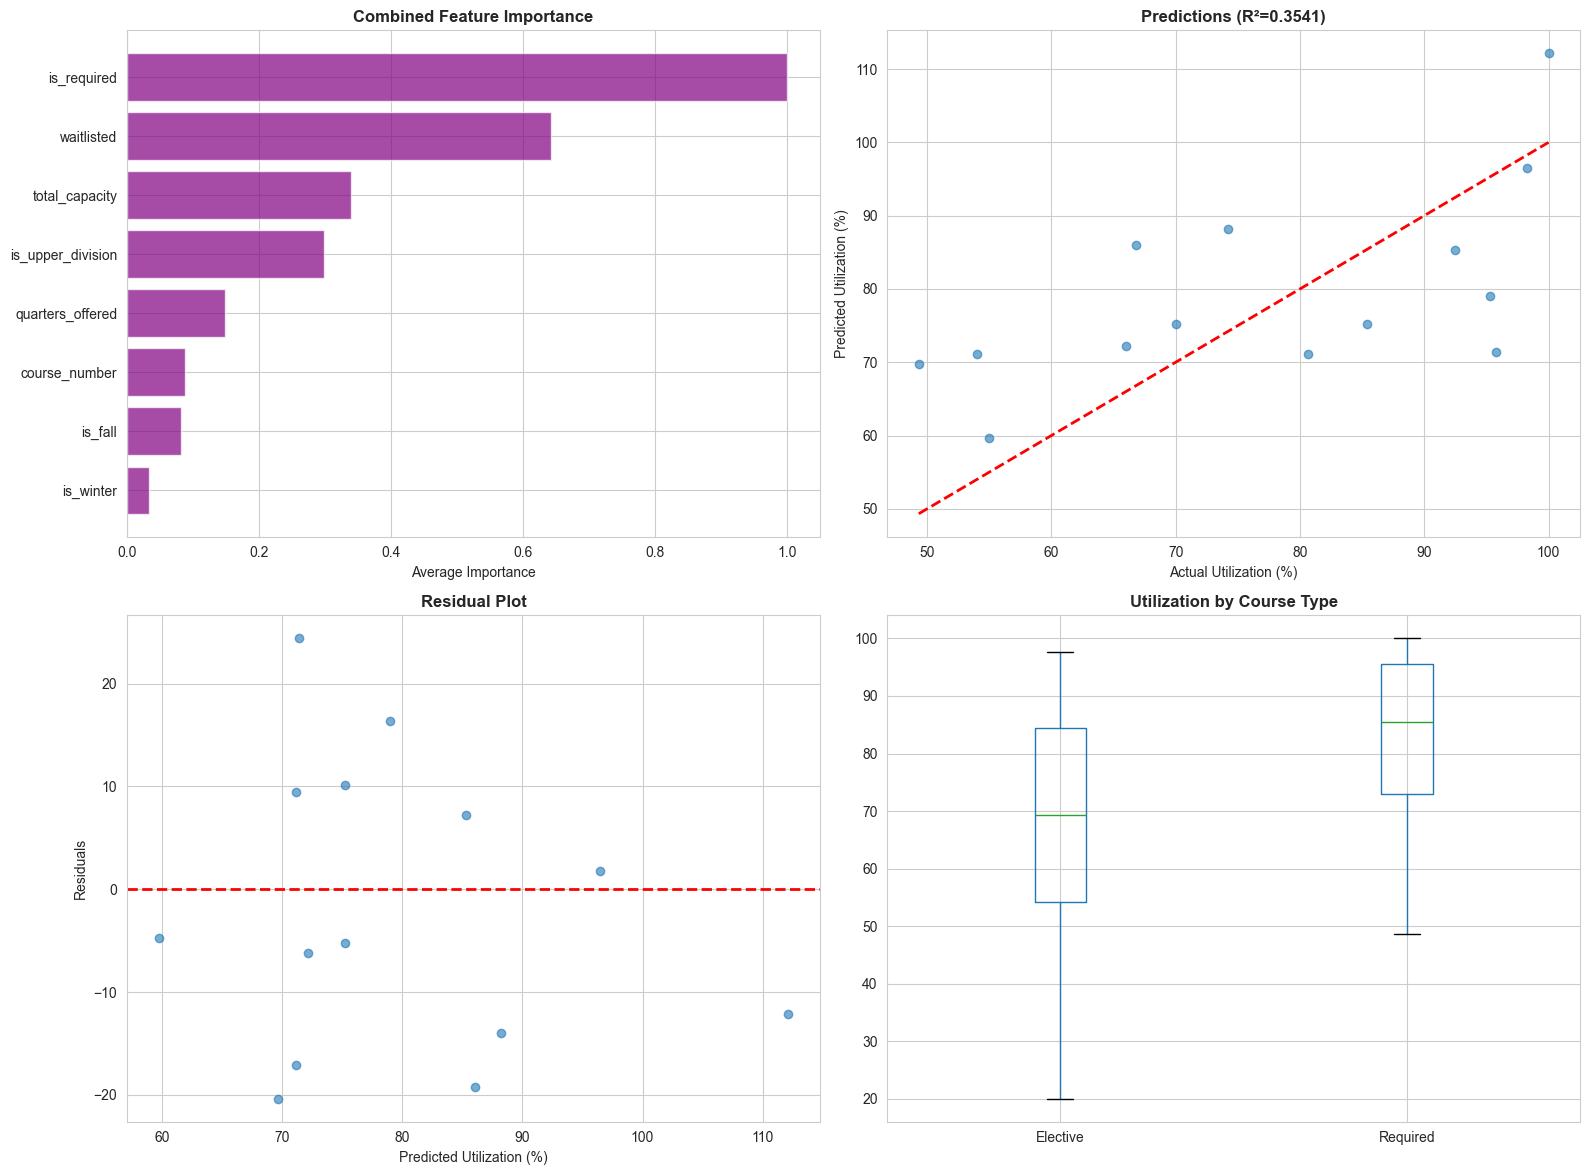

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Feature importance bar plot
combined_plot = combined.sort_values('Average_Importance')
axes[0, 0].barh(combined_plot['Feature'], combined_plot['Average_Importance'], color='purple', alpha=0.7)
axes[0, 0].set_xlabel('Average Importance')
axes[0, 0].set_title('Combined Feature Importance', fontweight='bold')

# Actual vs Predicted
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Utilization (%)')
axes[0, 1].set_ylabel('Predicted Utilization (%)')
axes[0, 1].set_title(f'Predictions (R²={test_r2:.4f})', fontweight='bold')

# Residual plot
residuals = y_test - y_test_pred
axes[1, 0].scatter(y_test_pred, residuals, alpha=0.6)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Utilization (%)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot', fontweight='bold')

# Box plots by type
df['division_label'] = df['division'].map({'lower_division': 'Lower', 'upper_division': 'Upper'})
comparison_data = pd.DataFrame({
    'Utilization': pd.concat([df[df['is_required']==1]['utilization_rate'], 
                              df[df['is_required']==0]['utilization_rate']]),
    'Type': ['Required']*len(df[df['is_required']==1]) + ['Elective']*len(df[df['is_required']==0])
})
comparison_data.boxplot(column='Utilization', by='Type', ax=axes[1, 1])
axes[1, 1].set_title('Utilization by Course Type', fontweight='bold')
axes[1, 1].set_xlabel('')
plt.suptitle('')

plt.tight_layout()
plt.savefig('webreg_plots/analysis_summary.png', dpi=300, bbox_inches='tight')
plt.show()


## Final Summary: Hypothesis Testing Results

### Overall Conclusion

This analysis tested the hypothesis that course structure (requirement status and division level) predicts enrollment demand in DSC courses across FA24, WI25, and SP25.

---

### Hypothesis Test Results Summary

#### H₁ Part 1: Required vs. Elective Courses
**SUPPORTED**
- **Result**: t(43) = 2.98, p = 0.005 (SIGNIFICANT)
- **Effect Size**: Required courses show 17.18 percentage points higher utilization (82.69% vs. 65.51%)
- **Conclusion**: Strong evidence that requirement status is a major predictor of enrollment demand

#### H₁ Part 2: Lower vs. Upper Division  
**NOT SUPPORTED**
- **Result**: t(43) = -1.32, p = 0.19 (NOT SIGNIFICANT)
- **Effect**: Upper division actually showed slightly higher utilization (81.23% vs. 73.64%), though not significantly
- **Conclusion**: Division level alone does not predict utilization; no evidence of introductory course bottlenecks

#### H₁ Part 3: Courses Offered Once vs. Every Quarter
**TO BE DETERMINED** (see regression coefficients)
- Examine the `quarters_offered` coefficient in the multiple regression (Test 8)
- Check `is_every_quarter` in simple regression (Test 7)
- If negative and significant: courses offered less frequently have higher utilization

---

### Additional Findings

**Quarter Variation** (Test 3):
- No significant difference across FA24, WI25, SP25 (F = 0.069, p = 0.934)
- Enrollment patterns are stable across academic terms

**Interaction Effect** (Test 4):
- Two-way ANOVA examines whether requirement effect differs by division
- See ANOVA table for interaction p-value

**Oversubscription** (Test 5):
- No significant association between course type and being at capacity (χ² = 0.48, p = 0.49)
- Required courses have higher average utilization but aren't disproportionately oversubscribed

**Class Size** (Test 6):
- Weak positive correlation between capacity and utilization (r = 0.31, p = 0.04)
- Larger classes show slightly higher utilization, but effect is small

---

### Key Takeaway for Report

**Primary Finding**: **Requirement status is the dominant predictor** of course utilization in DSC courses. Required courses show significantly higher demand than electives (p = 0.005), with a substantial 17-point difference. However, division level (lower vs. upper) does not significantly predict utilization (p = 0.19).

**Implication**: When planning course capacity and scheduling, **whether a course is required matters far more than whether it's introductory or advanced**. Both lower and upper division required courses face similar high demand.

**For Policy**: Focus capacity expansion efforts on required courses regardless of division level, rather than assuming all lower-division courses need more seats.


## Quick Reference: All Statistical Test Results

For easy copying into your report:

| Test | Statistic | p-value | Significant? | Conclusion |
|------|-----------|---------|--------------|------------|
| **Test 1**: Required vs. Elective | t = 2.98 | 0.005 | **YES** | Required courses have 17.2 pp higher utilization |
| **Test 2**: Lower vs. Upper Division | t = -1.32 | 0.194 | NO | No significant difference by division level |
| **Test 3**: ANOVA Quarters | F = 0.069 | 0.934 | NO | Stable demand across quarters |
| **Test 4**: Two-Way ANOVA | See table | Varies | Mixed | Check main effects and interaction |
| **Test 5**: Chi-Square Oversubscription | χ² = 0.48 | 0.490 | NO | Course type not associated with being at capacity |
| **Test 6**: Correlation Capacity-Utilization | r = 0.314 | 0.036 | YES (weak) | Weak positive relationship |
| **Test 8**: Multiple Regression | R² = 0.354 | 0.021 | YES | Model explains 35% of variance |

### Effect Sizes (Practical Significance):

- **Required vs. Elective**: 82.69% vs. 65.51% (Δ = 17.18 pp)
- **Lower vs. Upper**: 73.64% vs. 81.23% (Δ = -7.59 pp, not significant)
- **Oversubscription rates**: Required 29.0% (9/31) vs. Elective 14.3% (2/14)

### Sample Sizes:

- Total observations: n = 45 (20 unique courses across 3 quarters)
- Required courses: n = 31
- Elective courses: n = 14  
- Lower division: n = 23
- Upper division: n = 22
